In [1]:
import pandas as pd
import geopandas as gpd
from pathlib import Path

import censusdis.data as ced

import divintseg as dis

In [2]:
INPUT_FILE = Path.home() / 'tmp' / '00-All-2020.geojson'

In [3]:
gdf_tracts = gpd.read_file(INPUT_FILE)

In [4]:
gdf_tracts.shape

(85062, 135)

In [5]:
leaf_variables = sorted([
    var for var in gdf_tracts.columns
    if var.startswith('hl_') or var.startswith('P2_') and var != 'P2_001N'
])

leaf_variables

['P2_005N',
 'P2_006N',
 'P2_007N',
 'P2_008N',
 'P2_009N',
 'P2_010N',
 'P2_013N',
 'P2_014N',
 'P2_015N',
 'P2_016N',
 'P2_017N',
 'P2_018N',
 'P2_019N',
 'P2_020N',
 'P2_021N',
 'P2_022N',
 'P2_023N',
 'P2_024N',
 'P2_025N',
 'P2_026N',
 'P2_027N',
 'P2_029N',
 'P2_030N',
 'P2_031N',
 'P2_032N',
 'P2_033N',
 'P2_034N',
 'P2_035N',
 'P2_036N',
 'P2_037N',
 'P2_038N',
 'P2_039N',
 'P2_040N',
 'P2_041N',
 'P2_042N',
 'P2_043N',
 'P2_044N',
 'P2_045N',
 'P2_046N',
 'P2_047N',
 'P2_048N',
 'P2_050N',
 'P2_051N',
 'P2_052N',
 'P2_053N',
 'P2_054N',
 'P2_055N',
 'P2_056N',
 'P2_057N',
 'P2_058N',
 'P2_059N',
 'P2_060N',
 'P2_061N',
 'P2_062N',
 'P2_063N',
 'P2_064N',
 'P2_066N',
 'P2_067N',
 'P2_068N',
 'P2_069N',
 'P2_070N',
 'P2_071N',
 'P2_073N',
 'hl_005N',
 'hl_006N',
 'hl_007N',
 'hl_008N',
 'hl_009N',
 'hl_010N',
 'hl_013N',
 'hl_014N',
 'hl_015N',
 'hl_016N',
 'hl_017N',
 'hl_018N',
 'hl_019N',
 'hl_020N',
 'hl_021N',
 'hl_022N',
 'hl_023N',
 'hl_024N',
 'hl_025N',
 'hl_026N',
 'hl

In [6]:
gdf_tracts.columns

Index(['id', 'STATE', 'COUNTY', 'TRACT', 'diversity', 'integration', 'P2_001N',
       'P2_005N', 'P2_006N', 'P2_007N',
       ...
       'P2_047N', 'P2_058N', 'P2_061N', 'P2_069N', 'hl_034N', 'hl_040N',
       'hl_064N', 'hl_069N', 'hl_071N', 'geometry'],
      dtype='object', length=135)

In [7]:
gdf_di = gdf_tracts[
    ['STATE', 'COUNTY', 'TRACT', 'diversity', 'integration', 'P2_001N', 'geometry']
].rename({'P2_001N': 'total_pop'}, axis='columns')

In [8]:
gdf_di = gdf_di[gdf_di['total_pop'] >= 1000]

In [9]:
gdf_di.shape

(83800, 7)

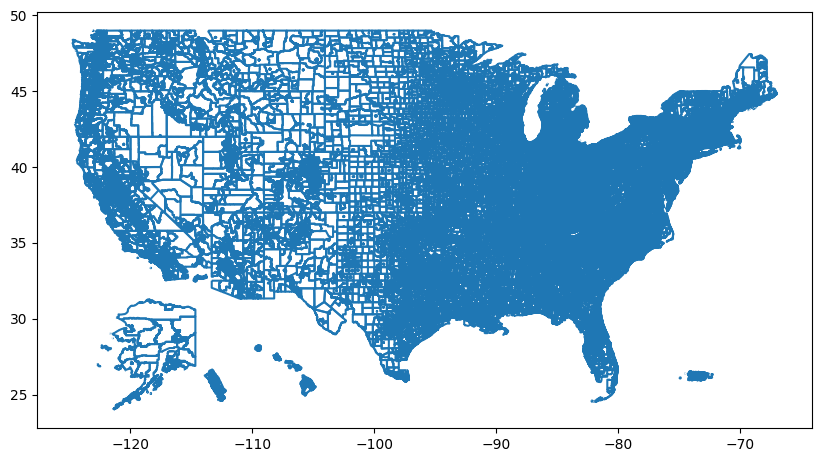

In [10]:
ax = gdf_di.boundary.plot(figsize=(10, 6))

## Find neighbors
Do a self-spatial join to find, for each tract, the others that intersect it
at it's boundaries. Then find all of those we can reach in one or two steps.
Then we will compute the mean difference from the diversity of it's neighbors 
to it.

In [ ]:
gdf_tracts_min = gdf_tracts[['STATE', 'COUNTY', 'TRACT', 'geometry']]

In [57]:
# Sparse adjacency matrix. It is directional so it contains
# to entries for each pair of adjacent tracts. It also
# includes self loop edges, one per tract.
df_adjacency = gdf_tracts_min.sjoin(gdf_tracts_min, lsuffix='a', rsuffix='b')[
    ['STATE_a', 'COUNTY_a', 'TRACT_a', 'STATE_b', 'COUNTY_b', 'TRACT_b']
]

In [88]:
# Average number of direct adjacent tracts, not
# counting the self-loop.
len(df_adjacency.index) / len(gdf_tracts_min.index) - 1

6.233147586466342

In [92]:
# Merge with self to get all paths of length 2 
# from tract a to adjacent tract b to adjacent
# tract b2.
# 
# Note that one or both of the edges in a length
# 2 path could be a self-loop, so for a given a
# we have a b2 for every tract that can be reached
# in 0, 1, or 2 adjacent tract steps.
#
# We rename the columns for convenience, and 
# drop duplicates so we have only one row
# for each (source, destination) pair even if
# there are mutliple paths of length <= 2 between
# them.
df_local = df_adjacency.merge(
    df_adjacency,
    left_on=['STATE_b', 'COUNTY_b', 'TRACT_b'],
    right_on=['STATE_a', 'COUNTY_a', 'TRACT_a'],
    suffixes = ["", "2"],
)[['STATE_a', 'COUNTY_a', 'TRACT_a', 'STATE_b2', 'COUNTY_b2', 'TRACT_b2']].rename(
    {
        'STATE_b2': 'STATE_b', 
        'COUNTY_b2': 'COUNTY_b', 
        'TRACT_b2': 'TRACT_b'
    },
    axis='columns'
).drop_duplicates()

In [93]:
df_local.shape

(1919618, 6)

In [94]:
# Filter out the self-loop from each group.
df_local = df_local[
    (df_local['STATE_a'] != df_local['STATE_b']) |
    (df_local['COUNTY_a'] != df_local['COUNTY_b']) |
    (df_local['TRACT_a'] != df_local['TRACT_b'])
]

In [95]:
df_local.shape

(1834556, 6)

In [96]:
# Average local neighborhood size, which is the 
# number of other tracts we can reach in one or 
# two steps, not counting the starting point.
len(df_local.index) / len(gdf_tracts_min.index)

21.567280336695585

In [97]:
df_local.columns

Index(['STATE_a', 'COUNTY_a', 'TRACT_a', 'STATE_b', 'COUNTY_b', 'TRACT_b'], dtype='object')

In [98]:
# Put the leaf variables for tract b into each row.
df_local_demographics = df_local.merge(
    gdf_tracts[['STATE', 'COUNTY', 'TRACT'] + leaf_variables],
    left_on = ['STATE_b', 'COUNTY_b', 'TRACT_b'],
    right_on = ['STATE', 'COUNTY', 'TRACT']
)

In [99]:
df_local_demographics.shape

(1834556, 135)

## Compute diversity over the entire surrounding neighborhood

In [130]:
df_neighboring_diversity = dis.diversity(
    df_local_demographics.groupby(
        ['STATE_a', 'COUNTY_a', 'TRACT_a']
    )[leaf_variables].sum()
).reset_index().rename(
    {'diversity': 'neigboring_diversity'}, axis='columns'
)

In [159]:
# Put tract a total population and diversity back in.
df_compare_diversity = df_neighboring_diversity.merge(
    gdf_tracts[['STATE', 'COUNTY', 'TRACT', 'COUNTY_NAME', 'P2_001N', 'diversity']],
    left_on = ['STATE_a', 'COUNTY_a', 'TRACT_a'],
    right_on = ['STATE', 'COUNTY', 'TRACT']
)[['STATE', 'COUNTY', 'TRACT', 'COUNTY_NAME', 'P2_001N', 'diversity', 'neigboring_diversity']]

In [160]:
df_compare_diversity['diff_diversity'] = (
    df_compare_diversity['diversity'] -
    df_compare_diversity['neigboring_diversity']
)

In [161]:
# Filter out nearly empty tracts that can have weird numbers.
df_compare_diversity = df_compare_diversity[df_compare_diversity['P2_001N'] >= 50]

In [164]:
df_compare_diversity.nlargest(25, 'diff_diversity')

,STATE,COUNTY,TRACT,COUNTY_NAME,P2_001N,diversity,neigboring_diversity,diff_diversity
84418,72,049,950500,"Culebra Municipio, Puerto Rico",1792.0,0.798584,0.000000,0.798584
29381,18,113,972200,"Noble County, Indiana",4904.0,0.728633,0.159275,0.569358
29936,19,021,960400,"Buena Vista County, Iowa",6745.0,0.829647,0.282157,0.547489
30015,19,047,070402,"Crawford County, Iowa",5285.0,0.757590,0.210863,0.546727
44567,29,211,480300,"Sullivan County, Missouri",2839.0,0.642615,0.099577,0.543038
30641,19,171,290500,"Tama County, Iowa",3851.0,0.704227,0.170310,0.533917
52530,36,065,026600,"Oneida County, New York",2152.0,0.687130,0.173179,0.513951
66266,42,119,980501,"Union County, Pennsylvania",547.0,0.689485,0.175691,0.513793
24953,17,017,960500,"Cass County, Illinois",2691.0,0.755374,0.242596,0.512778
28719,18,071,967901,"Jackson County, Indiana",6138.0,0.722073,0.209584,0.512489


In [163]:
df_compare_diversity.nsmallest(20, 'diff_diversity')

,STATE,COUNTY,TRACT,COUNTY_NAME,P2_001N,diversity,neigboring_diversity,diff_diversity
49364,35,043,940600,"Sandoval County, New Mexico",1991.0,0.037767,0.765981,-0.728213
2741,04,013,940700,"Maricopa County, Arizona",88.0,0.066632,0.756889,-0.690256
49106,35,006,941500,"Cibola County, New Mexico",3224.0,0.121949,0.789638,-0.667689
25439,17,031,340600,"Cook County, Illinois",1151.0,0.128693,0.795909,-0.667217
49366,35,043,940900,"Sandoval County, New Mexico",2307.0,0.092666,0.750704,-0.658038
49108,35,006,946100,"Cibola County, New Mexico",4040.0,0.169972,0.825899,-0.655927
1718,04,007,940400,"Gila County, Arizona",5531.0,0.080823,0.711195,-0.630372
36352,25,009,201100,"Essex County, Massachusetts",3334.0,0.171575,0.799897,-0.628322
2997,04,019,004133,"Pima County, Arizona",2500.0,0.106265,0.715820,-0.609555
36041,24,510,250204,"Baltimore city, Maryland",3853.0,0.103234,0.711866,-0.608632


In [ ]:
# Look at data from https://www.prisonpolicy.org/.

In [158]:
list(gdf_tracts.columns)

['id',
 'STATE',
 'COUNTY',
 'TRACT',
 'diversity',
 'integration',
 'P2_001N',
 'P2_005N',
 'P2_006N',
 'P2_007N',
 'P2_008N',
 'P2_009N',
 'P2_010N',
 'P2_013N',
 'P2_014N',
 'P2_015N',
 'P2_016N',
 'P2_017N',
 'P2_018N',
 'P2_019N',
 'P2_020N',
 'P2_021N',
 'P2_022N',
 'P2_023N',
 'P2_024N',
 'P2_025N',
 'P2_026N',
 'P2_027N',
 'P2_029N',
 'P2_030N',
 'P2_031N',
 'P2_032N',
 'P2_033N',
 'P2_034N',
 'P2_035N',
 'P2_036N',
 'P2_037N',
 'P2_038N',
 'P2_039N',
 'P2_040N',
 'P2_041N',
 'P2_042N',
 'P2_043N',
 'P2_044N',
 'P2_045N',
 'P2_046N',
 'P2_048N',
 'P2_050N',
 'P2_051N',
 'P2_052N',
 'P2_053N',
 'P2_054N',
 'P2_055N',
 'P2_056N',
 'P2_057N',
 'P2_059N',
 'P2_060N',
 'P2_062N',
 'P2_063N',
 'P2_064N',
 'P2_066N',
 'P2_067N',
 'P2_068N',
 'P2_070N',
 'P2_071N',
 'P2_073N',
 'hl_005N',
 'hl_006N',
 'hl_007N',
 'hl_008N',
 'hl_009N',
 'hl_010N',
 'hl_013N',
 'hl_014N',
 'hl_015N',
 'hl_016N',
 'hl_017N',
 'hl_018N',
 'hl_019N',
 'hl_020N',
 'hl_021N',
 'hl_022N',
 'hl_023N',
 'hl_024